In [1]:
# Standard libraries
from copy import deepcopy

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interactive, IntProgress
from IPython.display import display

# Append base directory
import os,sys,inspect
rootname = "neuronal-sequence-test"
thispath = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
rootpath = os.path.join(thispath[:thispath.index(rootname)], rootname)
sys.path.append(rootpath)
print("Appended root directory", rootpath)

from scipy.stats import mannwhitneyu

# User libraries
from mesostat.utils.qt_helper import gui_fnames, gui_fpath
from mesostat.stat.machinelearning import binary_classifier
from mesostat.utils.arrays import numpy_merge_dimensions
from mesostat.stat.connectomics import offdiag_1D

from src.lib.data_db import BehaviouralNeuronalDatabase
import src.lib.plots_lib as plots_lib
from src.lib.metric_wrapper import metric_by_interval, metric_by_phase
from src.lib.extra_metrics import num_non_zero_std, num_sample
from src.lib.stat_lib import cluster_dist_matrix


%load_ext autoreload
%autoreload 2

Appended root directory /home/alyosha/work/git/neuronal-sequence-test


In [2]:
# tmp_path = root_path_data if 'root_path_data' in locals() else "./"
params = {}
#params['root_path_data']  = gui_fpath("Path to data files", "./")
params['root_path_data'] = '/media/alyosha/Data/TE_data/mariadata/'
#params['root_path_data'] = '/media/alyosha/Data/TE_data/mariadata/postselect/'

In [3]:
dataDB = BehaviouralNeuronalDatabase(params)

In [4]:
dataDB.read_neuro_files()

IntProgress(value=0, description='Read Neuro Data:', max=27)

In [5]:
dataDB.read_behavior_files()

IntProgress(value=0, description='Read Neuro Data:', max=27)

No trials found for Trial_LWhole_Mistake skipping
No trials found for Trial_RWhole_Mistake skipping
No trials found for Trial_LWhole_Mistake skipping


In [6]:
for idx, row in dataDB.metaDataFrames['neuro'].iterrows():
    dataThis = dataDB.get_data_from_phase("Maintenance", {"mousekey" : row['mousekey'], "performance" : "Mistake"})
    print(row['mousekey'], len(dataThis), dataThis[0].shape[0], np.mean([data.shape[1] for data in dataThis]))

m068_20200130 17 28 169.47058823529412
m068_20200131 17 28 247.05882352941177
m068_20200203 10 28 153.4
m068_20200204 16 28 156.125
m068_20200205 3 28 167.0
m060_20190522 6 88 145.0
m060_20190524 7 88 151.42857142857142
m060_20190527 6 88 155.16666666666666
m060_20190606 1 88 183.0
m061_20190517 3 46 153.0
m061_20190524 6 46 244.66666666666666
m061_20190527 7 46 138.85714285714286
m065_20191128 10 83 190.3
m065_20191204 18 83 171.5
m065_20191205 13 83 163.0
m065_20191206 11 83 140.9090909090909
m065_20191209 5 83 177.6
m066_20191128 4 47 175.75
m066_20191205 7 47 272.14285714285717
m066_20191206 7 47 153.71428571428572
m066_20191218 12 47 254.58333333333334
m066_20191223 7 47 198.0
m067_20200115 6 49 256.0
m067_20200203 6 49 211.0
m067_20200204 10 49 263.8
m067_20200218 13 49 148.84615384615384
m067_20200219 8 49 268.875


# 1. Neuron-Time-Average

**Goal**: Attempt to predict phase from mean activity over trial

# 2 Time-Average

**Goal**: Attempt to predict phase from average activities of individual cells.
* Count predictive cells in each mouse

# 3.1 Table - Discriminate Phases by Metric

In [89]:
%%time
dataDB.verbose = False

phases = ['Encoding', 'Maintenance', 'Retrieval']
settings = {"serial" : True, "metricSettings" : {"metric" : num_non_zero_std}}  # {"metricSettings" : None, "sweepSettings" : None, "zscoreChannel" : None}
#settings = {"serial" : True, "zscoreChannel" : False, "metricSettings" :{"max_lag" : 1}}
sweepDict = {
    "datatype": ["raw", "high"],
    "performance": ["Correct", "Mistake", "All"],
    "direction": ["L", "R", "All"]
}

plots_lib.table_discriminate_phases(dataDB, sweepDict,
                                         phases,
                                         "avgcorr",
                                         trgDimOrder="r",
                                         settings=settings, multiplexKey="mousekey")

/opt/anaconda3/envs/py36nest/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/opt/anaconda3/envs/py36nest/lib/python3.6/site-packages/numpy/lib/function_base.py:2401: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


,datatype,performance,direction,Encoding,Maintenance,Retrieval,"-logp(0, 1)","-logp(0, 2)","-logp(1, 2)",nTrial
0,raw,Correct,L,0.247876,0.244396,0.245591,0.52,0.94,0.63,"[341, 341, 341]"
1,raw,Correct,R,0.254054,0.251253,0.254253,0.50,0.38,0.62,"[352, 352, 352]"
2,raw,Correct,All,0.251014,0.247879,0.249991,0.60,0.58,0.33,"[693, 693, 693]"
3,raw,Mistake,L,0.297944,0.287455,0.312180,0.85,1.02,1.63,"[81, 81, 81]"
4,raw,Mistake,R,0.243551,0.240404,0.254428,0.36,1.33,1.16,"[92, 92, 92]"
5,raw,Mistake,All,0.269018,0.262434,0.281468,0.63,1.59,2.10,"[173, 173, 173]"
6,raw,All,L,0.257486,0.252661,0.258372,0.75,0.49,0.45,"[422, 422, 422]"
7,raw,All,R,0.251877,0.249005,0.254289,0.45,0.76,0.99,"[444, 444, 444]"
8,raw,All,All,0.254611,0.250787,0.256279,0.74,0.42,0.92,"[866, 866, 866]"
9,high,Correct,L,0.336322,0.283940,0.335109,4.78,0.42,3.97,"[341, 341, 341]"


CPU times: user 24.5 s, sys: 10.5 s, total: 35 s
Wall time: 11.7 s


# 3.2 Violins - Metric by Phase and Interval

/opt/anaconda3/envs/py36nest/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


array([[ 0.  , -1.21, -0.91, -0.37],
       [-1.21,  0.  , -0.33, -0.88],
       [-0.91, -0.33,  0.  , -0.91],
       [-0.37, -0.88, -0.91,  0.  ]])

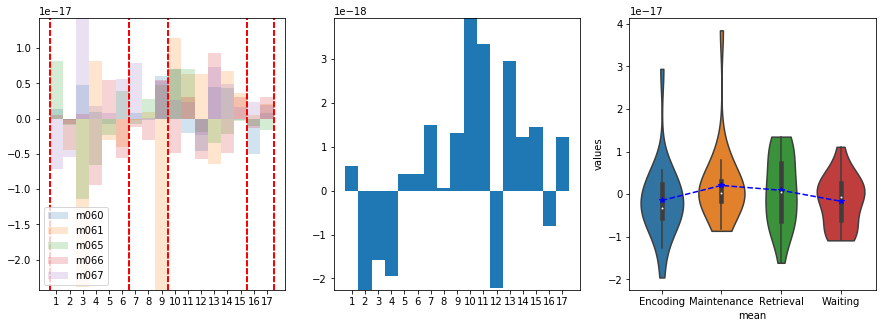

In [27]:
trgDimOrd = ''
metricName = "mean"
multiplexKey = "mousekey" # None

queryThis = {"datatype" : "raw", "performance" : "Correct"}  # "direction" : "R"
intervalOrigIndices = list(dataDB.metaDataFrames['interval_maps'][queryThis["performance"]]['index'])
boundingLines = dataDB.get_phase_bounding_lines(queryThis["performance"])
phases = dataDB.phases["Correct"]
settings = {"zscoreChannel" : True, "serial" : True, "metricSettings" : {"max_lag" : 1}}
#settings = {"zscoreChannel" : True, "serial" : True, "metricSettings" : {"metric" : num_non_zero_std}}  # {"metricSettings" : None, "sweepSettings" : None, "zscoreChannel" : None}

fig, ax = plt.subplots(ncols=3, figsize=(15,5))
for mousename in sorted(list(dataDB.mice)):
    queryMouse = deepcopy(queryThis)
    queryMouse["mousename"] = mousename
    
    rez2D = metric_by_interval(dataDB, queryMouse, metricName, trgDimOrd, settings, multiplexKey=multiplexKey)
    
    plots_lib.plot_labeled_bars(ax[0], rez2D, intervalOrigIndices, plotLabel=mousename, alpha=0.2)    
    plots_lib.plot_bar_bounds(ax[0], boundingLines)

    
rez2DIntervAll = metric_by_interval(dataDB, queryThis, metricName, trgDimOrd, settings, multiplexKey=multiplexKey)
rez2DPhaseAll = metric_by_phase(dataDB, queryThis, metricName, trgDimOrd, settings, multiplexKey=multiplexKey)
plots_lib.plot_labeled_bars(ax[1], rez2DIntervAll, intervalOrigIndices)
plots_lib.plot_labeled_violins(ax[2], rez2DPhaseAll, phases, metricName, joinMeans=True, printLogP=True)

ax[0].legend()
plt.show()

# 5. PCA trajectories